## Simple LDA

In [16]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [17]:
# load data from pickle oject
fiducial_pt_full =pd.read_pickle('fiducial_pt_full.pkl')
label_full = pd.read_pickle('label_full.pkl')

## Split into training & test set
X_train, X_test, y_train, y_test = train_test_split(fiducial_pt_full, label_full, test_size=0.2, random_state=42)

In [18]:
# pairwise distance calculation (can replace it with other feature engineering procedure)

# extract pairwise distance as features (78*77/2=3003 features)
# nrow=number of records of the dataset; ncol=3003
start_time = time.time()
feature_train = np.stack((metrics.pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((metrics.pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Test feature extraction takes %s seconds.'%round((time.time()-start_time),3))

/Users/XiangningHan/env_tools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Training feature extraction takes 1.199 seconds.


/Users/XiangningHan/env_tools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Test feature extraction takes 0.355 seconds.


In [12]:
#balance test set
emotion_1 = y_test[y_test == 1]
emotion_0 = y_test[y_test== 0]
feature_1 = feature_test[y_test==1]
feature_0 = feature_test[y_test==0]
bal_feature = np.concatenate((feature_1[0:130],feature_0[0:130]),axis=0)
bal_y = np.concatenate((emotion_1[0:130],emotion_0[0:130]),axis=0)

## Train LDA model

In [13]:
start=time.time()
clf_lda = LinearDiscriminantAnalysis()
model_lda=clf_lda.fit(feature_train, y_train)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 20.34 s


In [30]:
start=time.time()
print('accuracy', model_lda.score(feature_test,y_test).round(6))
prob_test = model_lda.predict_proba(feature_test)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(y_test, prob_test[:,1])}')
print('Testing time cost {:.2f} s'.format(time.time()-start))

accuracy 0.581667
Test ROC AUC  Score: 0.5446870269511073
Testing time cost 0.14 s


Weighted accuracy

In [27]:
weight_data = np.zeros(len(y_test))
y_pred=model_lda.predict(feature_test)
for v in np.unique(y_test):
    weight_data[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_data * (y_pred==y_test)/np.sum(weight_data))
print('weighted accuracy',weighted_acc)

weighted accuracy 0.526763838386991


##balanced test

In [33]:
print('accuracy', model_lda.score(bal_feature,bal_y).round(6))
prob_test = model_lda.predict_proba(bal_feature)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(bal_y, prob_test[:,1])}')

accuracy 0.665385
Test ROC AUC  Score: 0.6884023668639054


In [49]:
#lda with shrinkage
start=time.time()
clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(feature_train, y_train)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 23.01 s


In [50]:
print('accuracy', clf1.score(feature_test,y_test).round(6))
prob_test = clf1.predict_proba(feature_test)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(y_test, prob_test[:,1])}')

accuracy 0.83
pred prob
 [[0.9881618  0.0118382 ]
 [0.9986068  0.0013932 ]
 [0.99878647 0.00121353]
 ...
 [0.98432139 0.01567861]
 [0.98704607 0.01295393]
 [0.93085743 0.06914257]]


## PCA with LDA

In [168]:
##choose main component
def zeroMean(dataMat):      
    meanVal=np.mean(dataMat,axis=0)
    newData=dataMat-meanVal
    return newData,meanVal
def pca(dataMat,n):
    newData,meanVal=zeroMean(dataMat)
    covMat=np.cov(newData,rowvar=0)
    
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    eigValIndice=np.argsort(eigVals)          
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   
    n_eigVect=eigVects[:,n_eigValIndice]        
    lowDDataMat=newData*n_eigVect               
    reconMat=(lowDDataMat*n_eigVect.T)+meanVal  
    return lowDDataMat,reconMat,eigVals
def percentage2n(eigVals,percentage):
    sortArray=np.sort(eigVals)  
    sortArray=sortArray[-1::-1]  
    arraySum=sum(sortArray)
    tmpSum=0
    num=0
    for i in sortArray:
        tmpSum+=i
        num+=1
        if tmpSum>=arraySum*percentage:
            return num
main_component=percentage2n(pca(feature_train,3003)[2],0.96)

34

## Use explained variance to chose main component

Text(0, 0.5, 'cumulative explained variance')

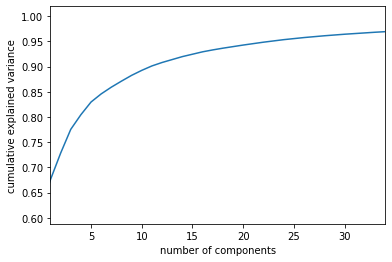

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
feature_train = sc.fit_transform(feature_train)
feature_test = sc.transform(feature_test)

from sklearn.decomposition import PCA
clf_pca=PCA()
x_train=clf_pca.fit(feature_train).transform(feature_train)
x_test=clf_pca.fit(feature_test).transform(feature_test)

import matplotlib.pyplot as plt
plt.plot(np.cumsum(clf_pca.explained_variance_ratio_))
plt.xlim((1,40))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [20]:
from sklearn.decomposition import PCA
n_components=main_component
pca = PCA(n_components=n_components).fit(feature_train)
X_train_pca = pca.transform(feature_train)
X_test_pca = pca.transform(feature_test)


## Applied LDA

In [21]:
start=time.time()
clf_pca_lda = LinearDiscriminantAnalysis()
clf_pca_lda.fit(X_train_pca, y_train)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 0.02 s


In [31]:
start=time.time()
prob_test=clf_pca_lda.predict_proba(X_test_pca)
print('accuracy',clf_pca_lda.score(X_test_pca,y_test).round(6))
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(y_test, prob_test[:,1])}')
print('Testing time cost {:.2f} s'.format(time.time()-start))

accuracy 0.8
Test ROC AUC  Score: 0.715819535261162
Testing time cost 0.02 s


In [28]:
weight_data = np.zeros(len(y_test))
y_pred_pca=clf_pca_lda.predict(X_test_pca)
for v in np.unique(y_test):
    weight_data[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_data * (y_pred_pca==y_test)/np.sum(weight_data))
print('weighted accuracy',weighted_acc)

weighted accuracy 0.5909580361740976
